In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 #-----To install specific version 3.7 of python in Google Colab-----
#!sudo apt-get install python3.7
#!sudo apt-get update -y
#!sudo update-alternatives --install /usr/bin/python3 python3/usr/bin/python3.7 1
#0!sudo update-alternatives --config python3

In [ ]:
!python3 --version

Python 3.10.11


In [ ]:
#!sudo apt install python3-pip

In [ ]:
#!python -m pip install --upgrade --force-reinstall pip

In [ ]:
!pip install tensorflow==2.11.0
#!pip install keras==2.3.1
#!pip install tensorflow==2.4.1

#!pip install git+https://www.github.com/keras-team/keras-contrib.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 112.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 48.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.0
    Uninstalling tensorboard-data-server-0.7.0:
      Successfully uninstalled tensorboard-data-ser

In [ ]:
#!pip install git+https://www.github.com/keras-team/keras-contrib.git

In [ ]:
%cd /content/drive/MyDrive/Cyclegans

/content/drive/MyDrive/Cyclegans


In [ ]:
# monet2photo #underwater enhancement
from os import listdir
from numpy import asarray
from numpy import vstack
import numpy as np
from numpy.random import randint
from matplotlib import pyplot as plt

In [ ]:
from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.optimizers import Adam
#from keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
#from tensorflow.keras.models import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import ZeroPadding2D

In [ ]:
from instancenorm import InstanceNormalization

In [ ]:
# discriminator model (70x70 patchGAN)
# C64-C128-C256-C512
# After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  
# The “axis” argument is set to -1 for instance norm. to ensure that features are normalized per feature map.
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512: 4x4 kernel Stride 2x2 
    # Not in the original paper. Comment this block if you want.
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = Model(in_image, patch_out)
	# compile model
	# The model is trained with a batch size of one image and Adam opt. 
	# with a small learning rate and 0.5 beta. 
	# The loss for the discriminator is weighted by 50% for each model update.
	# This slows down changes to the discriminator relative to the generator model during training.
	model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [ ]:
# generator a resnet block to be used in the generator
# residual block that contains two 3 × 3 convolutional layers with the same number of filters on both layers.
def resnet_block(n_filters, input_layer):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# first convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# second convolutional layer
	g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	# concatenate merge channel-wise with input layer
	g = Concatenate()([g, input_layer])
	return g

In [ ]:
# define the  generator model - encoder-decoder type architecture

#c7s1-k denote a 7×7 Convolution-InstanceNorm-ReLU layer with k filters and stride 1. 
#dk denotes a 3 × 3 Convolution-InstanceNorm-ReLU layer with k filters and stride 2.
# Rk denotes a residual block that contains two 3 × 3 convolutional layers
# uk denotes a 3 × 3 fractional-strided-Convolution InstanceNorm-ReLU layer with k filters and stride 1/2

#The network with 6 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3

#The network with 9 residual blocks consists of:
#c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128, u64,c7s1-3

def define_generator(image_shape, n_resnet=9):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# image input
	in_image = Input(shape=image_shape)
	# c7s1-64
	g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d128
	g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# d256
	g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# R256
	for _ in range(n_resnet):
		g = resnet_block(256, g)
	# u128
	g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# u64
	g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	g = Activation('relu')(g)
	# c7s1-3
	g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
	g = InstanceNormalization(axis=-1)(g)
	out_image = Activation('tanh')(g)
	# define model
	model = Model(in_image, out_image)
	return model

In [ ]:
# define a composite model for updating generators by adversarial and cycle loss
#We define a composite model that will be used to train each generator separately. 
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
	# Make the generator of interest trainable as we will be updating these weights.
    #by keeping other models constant.
    #Remember that we use this same function to train both generators,
    #one generator at a time. 
	g_model_1.trainable = True
	# mark discriminator and second generator as non-trainable
	d_model.trainable = False
	g_model_2.trainable = False
    
	# adversarial loss
	input_gen = Input(shape=image_shape)
	gen1_out = g_model_1(input_gen)
	output_d = d_model(gen1_out)
	# identity loss
	input_id = Input(shape=image_shape)
	output_id = g_model_1(input_id)
	# cycle loss - forward
	output_f = g_model_2(gen1_out)
	# cycle loss - backward
	gen2_out = g_model_2(input_id)
	output_b = g_model_1(gen2_out)
    
	# define model graph
	model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])
	
  # define the optimizer
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	# compile model with weighting of least squares loss and L1 loss
	model.compile(loss=['mse', 'mae', 'mae', 'mae'], 
               loss_weights=[1, 5, 10, 10], optimizer=opt)
	return model

In [ ]:
# select a batch of random samples, returns images and target
#Remember that for real images the label (y) is 1. 
def generate_real_samples(dataset, n_samples, patch_shape):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return X, y


In [ ]:
# load and prepare training images
def load_real_samples(filename):
	# load the dataset
	data = load(filename)
	# unpack arrays
	X1, X2 = data['arr_0'], data['arr_1']
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

In [ ]:
# generate a batch of images, returns images and targets
#Remember that for fake images the label (y) is 0. 
def generate_fake_samples(g_model, dataset, patch_shape):
	# generate fake images
	X = g_model.predict(dataset)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [ ]:
# periodically save the generator models to file
def save_models(step, g_model_AtoB, g_model_BtoA):
	# save the first generator model
	filename1 = 'g_model_AtoB_%06d.h5' % (step+1)
	g_model_AtoB.save(filename1)
	# save the second generator model
	filename2 = 'g_model_BtoA_%06d.h5' % (step+1)
	g_model_BtoA.save(filename2)
	print('>Saved: %s and %s' % (filename1, filename2))


In [ ]:
# periodically generate images using the save model and plot input and output images
def summarize_performance(step, g_model, trainX, name, n_samples=5):
	# select a sample of input images
	X_in, _ = generate_real_samples(trainX, n_samples, 0)
	# generate translated images
	X_out, _ = generate_fake_samples(g_model, X_in, 0)
	# scale all pixels from [-1,1] to [0,1]
	X_in = (X_in + 1) / 2.0
	X_out = (X_out + 1) / 2.0
	# plot real images
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + i)
		plt.axis('off')
		plt.imshow(X_in[i])
	# plot translated image
	for i in range(n_samples):
		plt.subplot(2, n_samples, 1 + n_samples + i)
		plt.axis('off')
		plt.imshow(X_out[i])
	# save plot to file
	filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
	plt.savefig(filename1)
	plt.close()

In [ ]:
# update image pool for fake images to reduce model oscillation
# update discriminators using a history of generated images 
# rather than the ones produced by the latest generators.
# Original paper recommended keeping an image buffer that stores 
# the 50 previously created images.

def update_image_pool(pool, images, max_size=50):
	selected = list()
	for image in images:
		if len(pool) < max_size:
			# stock the pool
			pool.append(image)
			selected.append(image)
		elif random() < 0.5:
			# use image, but don't add it to the pool
			selected.append(image)
		else:
			# replace an existing image and use replaced image
			ix = randint(0, len(pool))
			selected.append(pool[ix])
			pool[ix] = image
	return asarray(selected)

In [ ]:
# train cyclegan models
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=1):
	# define properties of the training run
	n_epochs, n_batch, = epochs, 1  #batch size fixed to 1 as suggested in the paper
	# determine the output square shape of the discriminator
	n_patch = d_model_A.output_shape[1]
	# unpack dataset
	trainA, trainB = dataset
	# prepare image pool for fake images
	poolA, poolB = list(), list()
	# calculate the number of batches per training epoch
	bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
    
	# manually enumerate epochs
	for i in range(n_steps):
		# select a batch of real samples from each domain (A and B)
		X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
		X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
		# generate a batch of fake samples using both B to A and A to B generators.
		X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
		X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
		# update fake images in the pool. Remember that the paper suggstes a buffer of 50 images
		X_fakeA = update_image_pool(poolA, X_fakeA)
		X_fakeB = update_image_pool(poolB, X_fakeB)
        
		# update generator B->A via the composite model
		g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
		# update discriminator for A -> [real/fake]
		dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
		dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
		
    # update generator A->B via the composite model
		g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
		# update discriminator for B -> [real/fake]
		dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
		dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
		
		# summarize performance
		# Since our batch size =1, the number of iterations would be same as the size of our dataset.
		# In one epoch you'd have iterations equal to the number of images.
		# If you have 100 images then 1 epoch would be 100 iterations
		print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
		# evaluate the model performance periodically
		# If batch size (total images)=100, performance will be summarized after every 75th iteration.
		if (i+1) % (bat_per_epo * 1) == 0:
			# plot A->B translation
			summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
			# plot B->A translation
			summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
		if (i+1) % (bat_per_epo * 1) == 0:
			# save the models
            # #If batch size (total images)=100, model will be saved after 
            #every 75th iteration x 5 = 375 iterations.
			save_models(i, g_model_AtoB, g_model_BtoA)

In [ ]:
# load all images in a directory into memory
def load_images(path, size=(256,256)):
	data_list = list()
	# enumerate filenames in directory, assume all are images
	for filename in listdir(path):
		# load and resize the image
		pixels = load_img(path + filename, target_size=size)
		# convert to numpy array
		pixels = img_to_array(pixels)
		# store
		data_list.append(pixels)
	return asarray(data_list)

In [ ]:
%cd /content/drive/MyDrive/Cyclegans/EUVP Dataset

/content/drive/.shortcut-targets-by-id/1ZEql33CajGfHHzPe1vFxUFCMcP0YbZb3/EUVP Dataset


In [ ]:
# dataset path
path = 'Unpaired/'

In [ ]:
# load dataset A -
dataA_all = load_images(path + 'trainA/')
print('Loaded dataA: ', dataA_all.shape)

Loaded dataA:  (3205, 256, 256, 3)


In [ ]:
from sklearn.utils import resample

# To get a subset of all images, for faster training for now to check the working
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42) 
'''
#checking with all data
dataA = resample(dataA_all, 
                 replace=False,     
                 n_samples=1000,    
                 random_state=42) 
'''

'\n#checking with all data\ndataA = resample(dataA_all, \n                 replace=False,     \n                 n_samples=1000,    \n                 random_state=42) \n'

In [ ]:
# load dataset B - High quality images 
dataB_all = load_images(path + 'trainB/')
print('Loaded dataB: ', dataB_all.shape)
#Get a subset of all images, for faster training during demonstration
#We could have just read the list of files and only load a subset, better memory management.

Loaded dataB:  (3140, 256, 256, 3)


In [ ]:
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=500,    
                 random_state=42)

'''
dataB = resample(dataB_all, 
                 replace=False,     
                 n_samples=1000,    
                 random_state=42)
'''

'\ndataB = resample(dataB_all, \n                 replace=False,     \n                 n_samples=1000,    \n                 random_state=42)\n'

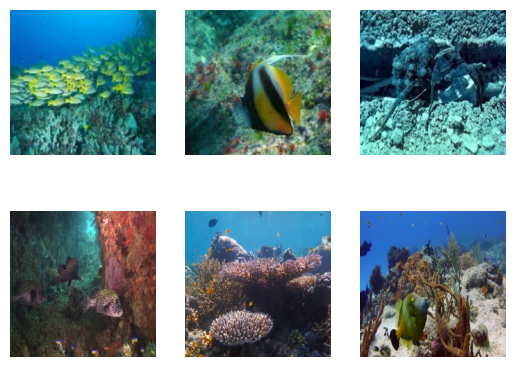

In [ ]:

# plot source images
n_samples = 3
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + i)
	plt.axis('off')
	plt.imshow(dataA[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	plt.subplot(2, n_samples, 1 + n_samples + i)
	plt.axis('off')
	plt.imshow(dataB[i].astype('uint8'))
plt.show()

In [ ]:
# load image data
data = [dataA, dataB]
#checking the shape
print('Loaded', data[0].shape, data[1].shape)

Loaded (500, 256, 256, 3) (500, 256, 256, 3)


In [ ]:
#Preprocess data to change input range to values between -1 and 1
# This is because the generator uses tanh activation in the output layer
#And tanh ranges between -1 and 1
def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [ ]:
%cd /content/drive/MyDrive/Cyclegans

/content/drive/MyDrive/Cyclegans


In [ ]:
#from tensorflow.python.framework.ops import disable_eager_execution

#disable_eager_execution()

In [ ]:
# define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# generator: A -> B
g_model_AtoB = define_generator(image_shape)
# generator: B -> A
g_model_BtoA = define_generator(image_shape)
# discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# composite: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# composite: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

'''
ERROR SOLN:
from tensorflow.python.framework import tensor_util
def is_tensor(x):                                                                                                                                                      
    return tensor_util.is_tensor(x)

'''


/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


'\nERROR SOLN:\nfrom tensorflow.python.framework import tensor_util\ndef is_tensor(x):                                                                                                                                                      \n    return tensor_util.is_tensor(x)\n\n'

In [ ]:
from datetime import datetime 
start1 = datetime.now() 
# train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset, epochs=4)

stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)

1/1 [==============================] - 0s 29ms/step
Iteration>1, dA[0.023,0.037] dB[0.334,0.085] g[5.287,5.349]
1/1 [==============================] - 0s 25ms/step
Iteration>2, dA[0.007,0.009] dB[0.045,0.381] g[5.998,7.241]
1/1 [==============================] - 0s 25ms/step


KeyboardInterrupt: ignored

In [ ]:
# Use the saved cyclegan models for image translation
#from instancenorm import InstanceNormalization  
# from tensorflow.keras.models import load_model
# from matplotlib import pyplot
# from numpy.random import randint

In [ ]:
# select a random sample of images from the dataset
def select_sample(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	return X


In [ ]:
# plot the image, its translation, and the reconstruction
def show_plot(imagesX, imagesY1, imagesY2):
	images = vstack((imagesX, imagesY1, imagesY2))
	titles = ['Real', 'Generated', 'Reconstructed']
	# scale from [-1,1] to [0,1]
	images = (images + 1) / 2.0
	# plot images row by row
	for i in range(len(images)):
		# define subplot
		plt.subplot(1, len(images), 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(images[i])
		# title
		plt.title(titles[i])
	plt.show()

In [ ]:
# load dataset

A_data = resample(dataA_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

B_data = resample(dataB_all, 
                 replace=False,     
                 n_samples=50,    
                 random_state=42) # reproducible results

A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5


In [ ]:
A_data.shape

(50, 256, 256, 3)

In [ ]:
# load the models
cust = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('/content/drive/MyDrive/Cyclegans/g_model_AtoB_000100.h5', cust)
model_BtoA = load_model('/content/drive/MyDrive/Cyclegans/g_model_BtoA_000100.h5', cust)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def custom_loss(real_image, generated_image):
  # converting to gray scale
  # gray= cv2.imread(generated_image[0]);

  gray = cv2.cvtColor(generated_image[0], cv2.IMREAD_GRAYSCALE)
  # img = io.imread(generated_image[0])
  # gray= skimage.color.rgb2gray(img)
  # remove noise
  img = cv2.GaussianBlur(gray,(3,3),0)
  # convolute with proper kernels
  sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=5)  #x
  sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=5)  #y
  # calculating the magnitude and angle
  magnitude = np.sqrt(sobelx**2.0 + sobely**2.0)
  angle = np.arctan2(sobely, sobelx) * (180 / np.pi)
  # Calculate sum of pixel intensities (number of nonzero matrix elements).
  sumIntensities = np.sum(np.sum(magnitude))
  # Number of pixels, whose intensity value is greater than a threshold in Sobel edge image.
  numberEdgels = np.count_nonzero(magnitude)
  # Calculate Entropy of enhanced image.
  p = cv2.calcHist([img],[0],None,[256],[0,256])
  entropy = -np.sum(np.dot(p[0],np.log2(p[0])))
  # Compute objective function which tells us about the quality of the input enhanced image.
  a = np.log(np.log(sumIntensities))
  b = numberEdgels/np.dot(img[0], img[1])
  oFit = np.maximum(np.dot(np.dot(a, b), entropy))
  
  return oFit

In [ ]:
import cv2
import numpy as np

def fitnessFunction(iE, iM, iN):
    """
    Function to evaluate the fitness value for new position.

    Parameters:
        iE (ndarray): Input enhanced image.
        iM (int): Number of columns.
        iN (int): Number of rows.

    Returns:
        float: Output computed objective function which tells us about
               the quality of the input enhanced image.
    """
    
    # Gradient magnitude and direction of an input enhanced image using Sobel gradient operator.
    EGrad = cv2.Sobel(iE, cv2.CV_64F, 1, 1)

    # Calculate sum of pixel intensities (number of nonzero matrix elements).
    sumIntensities = np.sum(EGrad)

    # Number of pixels, whose intensity value is greater than a threshold in Sobel edge image.
    numberEdgels = np.count_nonzero(EGrad)

    # Calculate Entropy of enhanced image.
    hist = cv2.calcHist([iE], [0], None, [256], [0, 256])
    hist_norm = hist / float(iM * iN)
    hist_norm = hist_norm[np.where(hist_norm != 0)]
    entropyEnh = -np.sum(hist_norm * np.log2(hist_norm))

    # Compute objective function which tells us about the quality of the input enhanced image.
    oFit = np.log(np.log(sumIntensities)) * (numberEdgels / (iM * iN)) * entropyEnh

    return oFit


1/1 [==============================] - 1s 1s/step


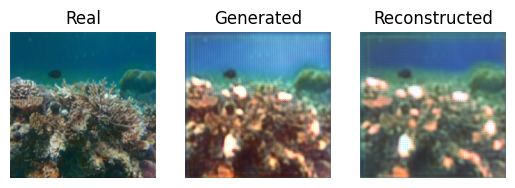

1/1 [==============================] - 0s 48ms/step


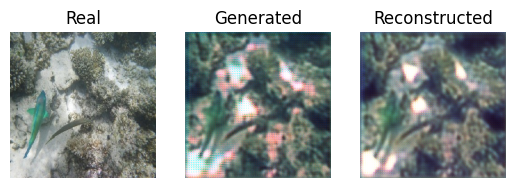

In [ ]:
# plot A->B->A (Monet to photo to Monet)
A_real = select_sample(A_data, 1)
B_generated  = model_AtoB.predict(A_real)
A_reconstructed = model_BtoA.predict(B_generated)
show_plot(A_real, B_generated, A_reconstructed)

# plot B->A->B (Photo to Monet to Photo)
B_real = select_sample(B_data, 1)
A_generated  = model_BtoA.predict(B_real)
B_reconstructed = model_AtoB.predict(A_generated)
show_plot(B_real, A_generated, B_reconstructed)

In [ ]:
enhanced=np.array(B_generated)
enhanced.dtype
enhanced.shape[1]

256

In [ ]:
custom_loss(A_real,B_generated)

ValueError: ignored

In [ ]:
fitnessFunction(B_generated, B_generated.shape[1],B_generated.shape[2])

In [ ]:
#single image
test_image = load_img('/content/drive/MyDrive/Cyclegans/EUVP Dataset/Unpaired/validation/test_9003up.jpg', target_size=(256,256))
test_image = img_to_array(test_image)
test_image_input = np.array([test_image])  # Convert single image to a batch.
test_image_input = (test_image_input - 127.5) / 127.5
test_image_input.shape

In [ ]:
# plot B->A->B (Photo to Monet to Photo)
generated_image = model_BtoA.predict(test_image_input)
photo_reconstructed = model_AtoB.predict(generated_image)
show_plot(test_image_input, generated_image, photo_reconstructed)